# Study case for Lou Morriet's PhD
# "Conception multiacteur de systèmes énergétiques locaux bas-carbone : outils, modèles et analyses qualitatives"

# Collective self consumption project : 10 dwellings as a prosumer


This module presents a multi-actor modelling study case for a simple collective self consumption project

The aim of this study case is to decide the number of PV pannels 
which should be installed considering the dwelling loads and the stakeholders objectives and constraints.
The module includes :
 - Ten dwelling loads with a fixed consumption profile
 - One PV production unit which can be multiplied
 - the network which can produce or consume the energy once required (modelled as a supplier production and consumption units)


![title](figures/Collective-self-consumption.PNG)


In [1]:

import os
import pandas as pd
from lpfics import lpfics
from pulp import LpStatus, PULP_CBC_CMD, COIN_CMD, GUROBI_CMD
import sys

sys.setrecursionlimit(5000)

from omegalpes.energy.energy_nodes import EnergyNode
from omegalpes.energy.units.production_units import *
from omegalpes.energy.units.consumption_units import *
from omegalpes.energy.units.reversible_units import ReversibleUnit
from omegalpes.energy.energy_types import elec

from omegalpes.actor.operator_actors.prosumer_actors import Prosumer
from omegalpes.actor.operator_actors.supplier_actors import Supplier
from omegalpes.actor.operator_actors.grid_operator_actors import \
    ElectricityGridOperator

from omegalpes.general.time import TimeUnit
from omegalpes.general.optimisation.model import OptimisationModel

from omegalpes.general.utils.input_data import read_enedis_data_csv_file, \
    select_csv_file_between_dates
from omegalpes.general.utils.plots import plt, plot_quantity, \
    plot_node_energetic_flows, plot_energy_mix, sum_quantities_in_quantity, \
    plot_quantity_bar, plot_pareto2D

from ipywidgets import widgets, Layout, Button, Box, FloatText, Textarea, \
    Dropdown, Label, IntSlider, FloatSlider, BoundedFloatText, ToggleButton, \
    BoundedIntText, HTML
from IPython.display import clear_output

In [2]:
# ------------------------------------------------------------------------------

# Module version
__version_info__ = (0, 3, 1)
__version__ = ".".join(str(x) for x in __version_info__)

# ------------------------------------------------------------------------------

## Optimization parameters

In [3]:
work_path = os.getcwd()
dt = 1 / 2

nb_prosumers = 10
pv_imaginary_boolean = False
pareto_boolean = False

## Operating steps followed by the code: 

In [4]:
time = TimeUnit(periods=24 * 2 / dt, dt=dt, start='10/11/2018')

You are studying the period from 2018-11-10 00:00:00 to 2018-11-11 23:30:00


2. Creating an empty model

In [5]:
model = OptimisationModel(time=time,
                              name='collective_selfconsumption_10_dwellings')

In [6]:
cons_data_list = []
cons_list = []
grid_node_list = []

4. Creating the energy units
	- 4.1 Creating the dwelling_consumptions from one to 10
	- 4.2 Creating the local_pv_production 
	- 4.3 Creating the supplier energy units (supplier_production & supplier_consumption)

In [7]:
    for i in range(nb_prosumers):
        cons_data_list.append(read_enedis_data_csv_file(
            file_path=
            work_path + '/data/{}_10112018_11112018_Conso_CDC.csv'.format(i),
            start='10/11/2018', end='12/11/2018'))

        cons_list.append(FixedConsumptionUnit(time=time,
                                              name='cons_{}'.format(i + 1),
                                              p=cons_data_list[i],
                                              energy_type=elec))

    # Create the PV production #
    pv_data = read_enedis_data_csv_file(
        file_path=work_path + '/data/A_10112018_11112018_Prod_CDC_normalised_250Wc.csv',
        start='10/11/2018', end='12/11/2018')
    pv = SeveralProductionUnit(time=time, name='pv',
                               fixed_prod=pv_data,
                               imaginary=pv_imaginary_boolean,
                               energy_type=elec)

    # Create the supplier production and consumption units #
    supply = ReversibleUnit(time=time, name='supply')

Creating the cons_1.
Creating the cons_2.
Creating the cons_3.
Creating the cons_4.
Creating the cons_5.
Creating the cons_6.
Creating the cons_7.
Creating the cons_8.
Creating the cons_9.
Creating the cons_10.
Creating the pv.
Creating the supply_prod.
Creating the supply_cons.
Creating the supply.


5. Creating the energy nodes and connecting units
	- 5.1 Creating the pv_elec_node
	- 5.2 Creating the supplier_elec_node
	- 5.3 Creating the dwelling_elec_node_1
	- 5.4 Creating the dwelling_elec_node_2

In [8]:
pv_node = EnergyNode(time=time, name='pv_node', energy_type=elec)
pv_node.connect_units(pv)

grid_node_list.append(EnergyNode(time=time, name='main_grid_node', energy_type=elec))
grid_node_list[0].connect_units(supply.consumption_unit,supply.production_unit)
grid_node_list[0].import_from_node(pv_node)

for i in range(nb_prosumers):
    grid_node_list.append(EnergyNode(time=time,
                                         name='grid_node_{}'.format(i + 1),
                                         energy_type=elec))
    grid_node_list[i + 1].connect_units(cons_list[i])
    grid_node_list[0].export_to_node(grid_node_list[i + 1])

    pv_node.export_to_node(grid_node_list[i + 1])

Creating the pv_node.
Creating the main_grid_node.
Creating the grid_node_1.
Creating the grid_node_2.
Creating the grid_node_3.
Creating the grid_node_4.
Creating the grid_node_5.
Creating the grid_node_6.
Creating the grid_node_7.
Creating the grid_node_8.
Creating the grid_node_9.
Creating the grid_node_10.


6. Creating the actors
	- 6.1 Creating the prosumer
	- 6.2 Creating the supplier_conso

In [9]:
legal_person = Prosumer(name='legal_person',
                            operated_consumption_unit_list=cons_list,
                            operated_production_unit_list=[pv],
                            operated_node_list=[pv_node]
                            )

supplier = Supplier(name='supplier',
                        operated_consumption_unit_list=[
                            supply.consumption_unit],
                        operated_production_unit_list=[
                            supply.production_unit],
                        operated_node_list=grid_node_list
                        )

grid_operator = ElectricityGridOperator(name='grid_operator',
                                            operated_node_list=grid_node_list)

Creating the legal_person.
Creating the supplier.
Creating the grid_operator.


Adding a maximum of the available number of PV pannels

In [10]:
legal_person.add_nb_unit_maximum(nb_unit_max=30*10, energy_unit=pv)

7. Adding objectives and actors 
Test Scenario 1 and then Scenario 2 commenting (adding # thanks to ctrl+/ once the code is selected) and uncommenting (removing # thanks to ctrl+/ once the code is selected) the cells corresponding to the scenarios.

	### Scenario 1: Maximise self-consumption rate

In [11]:
legal_person.maximize_selfconsumption_rate(
        time=time,
        obj_operated_production_unit_list=[pv],
        obj_operated_selfconsummed_production_export_list=
        [pv_node.get_exports[i] for i in range(1, 10)],
        pareto=pareto_boolean
    )


	### Scenario 2: Maximise self-production rate

In [12]:
# legal_person.maximize_selfproduction_rate(
#     time=time,
#     obj_operated_consumption_unit_list=cons_list,
#     obj_operated_selfproduced_consumption_export_list=
#     [pv_node.get_exports[i] for i in range(1, 10)],
#     pareto=pareto_boolean
# )


	### Scenario 3: Maximise consumption-production match

In [13]:
# legal_person.maximize_conso_prod_match(
#     time=time,
#     obj_operated_production_unit_list=[pv],
#     obj_operated_consumption_unit_list=cons_list,
#     pareto=pareto_boolean,
#     weight=1.0
# )

### You can test other available objectives for the prosumer
    Uncomment the objective you want ( removing # - thanks to ctrl+/ one the code is selected)

In [14]:
# CONSTRAINT 1: Maximum of energy transfer
# grid_operator.add_energy_transfer_maximum(
#     max_e_tot=0,
#     cst_operated_exports_list=[pv_node.get_exports[0]])

# OBJECTIVE 1: Minimize energy transfer over the grid
# grid_operator.minimize_energy_transfer(
#     obj_operated_exports_list=[pv_node.get_exports[0]],
#     pareto=pareto_boolean,
#     weight=1.0))


8. Adding the energy nodes and the actors to the model


In [15]:
model.add_nodes_and_actors(pv_node,
                               grid_node_list[0],
                               grid_node_list[1],
                               grid_node_list[2],
                               grid_node_list[3],
                               grid_node_list[4],
                               grid_node_list[5],
                               grid_node_list[6],
                               grid_node_list[7],
                               grid_node_list[8],
                               grid_node_list[9],
                               grid_node_list[10],
                               legal_person,
                               grid_operator,
                               supplier,
                               )


d:\modeleur_dev\dev_omegalpes\omegalpes\general\optimisation\model.py:567: UserWarning: The unit pv_node seems to have as parent set_export_min_grid_node_3_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
d:\modeleur_dev\dev_omegalpes\omegalpes\general\optimisation\model.py:567: UserWarning: The unit pv_node seems to have as parent set_export_min_grid_node_4_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
d:\modeleur_dev\dev_omegalpes\omegalpes\general\optimisation\model.py:567: UserWarning: The unit pv_node seems to have as parent set_export_min_grid_node_5_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
d:\modeleur_dev\dev_omegalpes\omegalpes\general\optimisation\model.py:567: UserWarning: The unit pv_node seems to have as parent set_export_min_grid_node_6_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
d:\modeleur_dev\dev_omegalpes\omegalpes\general\


--- Adding all variables to the model ---
Adding variable : pv_node_energy_export_to_main_grid_node
Adding variable : pv_node_is_exporting_to_main_grid_node
Adding variable : pv_node_energy_export_to_grid_node_1
Adding variable : pv_node_is_exporting_to_grid_node_1
Adding variable : pv_node_energy_export_to_grid_node_2
Adding variable : pv_node_is_exporting_to_grid_node_2
Adding variable : pv_node_energy_export_to_grid_node_3
Adding variable : pv_node_is_exporting_to_grid_node_3
Adding variable : pv_node_energy_export_to_grid_node_4
Adding variable : pv_node_is_exporting_to_grid_node_4
Adding variable : pv_node_energy_export_to_grid_node_5
Adding variable : pv_node_is_exporting_to_grid_node_5
Adding variable : pv_node_energy_export_to_grid_node_6
Adding variable : pv_node_is_exporting_to_grid_node_6
Adding variable : pv_node_energy_export_to_grid_node_7
Adding variable : pv_node_is_exporting_to_grid_node_7
Adding variable : pv_node_energy_export_to_grid_node_8
Adding variable : pv_nod

Adding constraint : main_grid_node_set_export_to_grid_node_5_max , exp = main_grid_node_is_exporting_to_grid_node_5[t] * 100000.0 >= main_grid_node_energy_export_to_grid_node_5[t] for t in time.I
Adding constraint : main_grid_node_set_export_min_grid_node_6_min , exp = main_grid_node_is_exporting_to_grid_node_6[t] * 1e-05 <= main_grid_node_energy_export_to_grid_node_6[t] for t in time.I
Adding constraint : main_grid_node_set_export_to_grid_node_6_max , exp = main_grid_node_is_exporting_to_grid_node_6[t] * 100000.0 >= main_grid_node_energy_export_to_grid_node_6[t] for t in time.I
Adding constraint : main_grid_node_set_export_min_grid_node_7_min , exp = main_grid_node_is_exporting_to_grid_node_7[t] * 1e-05 <= main_grid_node_energy_export_to_grid_node_7[t] for t in time.I
Adding constraint : main_grid_node_set_export_to_grid_node_7_max , exp = main_grid_node_is_exporting_to_grid_node_7[t] * 100000.0 >= main_grid_node_energy_export_to_grid_node_7[t] for t in time.I
Adding constraint : main

9. Optimisation process

In [16]:
model.solve_and_update(find_infeasible_cst_set=True, pareto_step=0.05, solver=PULP_CBC_CMD())


 - - - - - RUN OPTIMIZATION - - - - - 

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : pv_node
	Quantity : energy_export_to_main_grid_node
	Quantity : is_exporting_to_main_grid_node
	Quantity : energy_export_to_grid_node_1
	Quantity : is_exporting_to_grid_node_1
	Quantity : energy_export_to_grid_node_2
	Quantity : is_exporting_to_grid_node_2
	Quantity : energy_export_to_grid_node_3
	Quantity : is_exporting_to_grid_node_3
	Quantity : energy_export_to_grid_node_4
	Quantity : is_exporting_to_grid_node_4
	Quantity : energy_export_to_grid_node_5
	Quantity : is_exporting_to_grid_node_5
	Quantity : energy_export_to_grid_node_6
	Quantity : is_exporting_to_grid_node_6
	Quantity : energy_export_to_grid_node_7
	Quantity : is_exporting_to_grid_node_7
	Quantity : energy_export_to_grid_node_8
	Quantity : is_exporting_to_grid_node_8
	Quantity : energy_export_to_grid_node_9
	Quantity : is_exporting_to_grid_node_9
	Quantity : energy_export_to_grid_node_10
	Quantity : is_exporting_to_grid_node_10

Now you can print results


 - - - - - OPTIMISATION RESULTS - - - - - 
the total consumption of dwelling 0 is 5.96 kWh
the total consumption of dwelling 1 is 28.336 kWh
the total consumption of dwelling 2 is 8.837 kWh
the total consumption of dwelling 3 is 5.147 kWh
the total consumption of dwelling 4 is 23.831 kWh
the total consumption of dwelling 5 is 12.401 kWh
the total consumption of dwelling 6 is 8.85 kWh
the total consumption of dwelling 7 is 7.613 kWh
the total consumption of dwelling 8 is 52.818 kWh
the total consumption of dwelling 9 is 9.826 kWh
the total consumption is 163.619 kWh
the number of pv is 13.0
the total production is 5.7437656 kWh
the pv exports are 0.0 kWh
the supply imports are 157.87523000000002 kWh




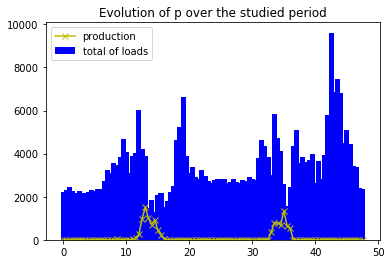

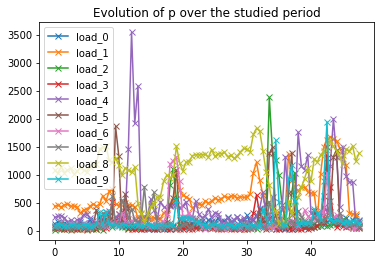

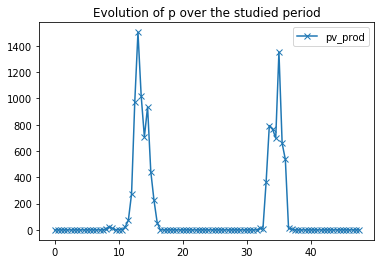

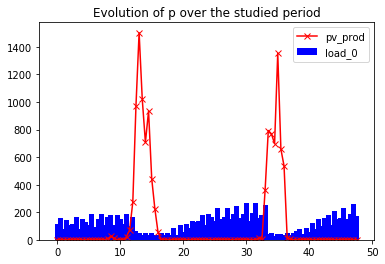

In [17]:
    if not pareto_boolean:
        if LpStatus[model.status] == 'Optimal':
            print("\n - - - - - OPTIMISATION RESULTS - - - - - ")

            for i in range(nb_prosumers):
                print("the total consumption of dwelling {0} is "
                      "{1} kWh".format(i, cons_list[i].e_tot.get_value() / 1000))
            print("the total consumption is {} kWh".format(
                sum(cons_list[i].e_tot.get_value() for i in
                    range(nb_prosumers)) / 1000))

            print("the number of pv is {}".format(
                pv.nb_unit.get_value()))
            print("the total production is {} kWh".format(
                pv.e_tot.get_value() / 1000))

            print("the pv exports are {} kWh".format(
                sum(pv_node.get_exports[0].get_value()) / 1000 * dt))
            print("the supply imports are {} kWh".format(
                supply.production_unit.e_tot.get_value() / 1000))

            print('\n')

            # # # Plot the figures # #
            fig1 = plt.figure(1)
            ax1 = plt.axes()

            loads = sum_quantities_in_quantity(
                quantities_list=[cons_list[i].p for i in range(nb_prosumers)])
            plot_quantity_bar(time, loads, fig1, ax1, label='total of loads',
                              color='b')

            plot_quantity(time, pv.p, fig1, ax1, label='production',
                          color='y')

            ax1.legend()

            #############################################

            fig2 = plt.figure(2)
            ax2 = plt.axes()

            for i in range(nb_prosumers):
                plot_quantity(time, cons_list[i].p, fig2, ax2,
                              label='load_{}'.format(i))

            ax2.legend()

            #############################################

            fig4 = plt.figure(4)
            ax4 = plt.axes()

            plot_quantity(time, pv.p, fig4, ax4,
                          label='pv_prod')

            ax4.legend()

            ############################################
            fig3 = plt.figure(3)
            ax3 = plt.axes()

            plot_quantity_bar(time, cons_list[0].p, fig3, ax3, color='b',
                              label='load_0')
            plot_quantity(time, pv.p, fig3, ax3, color='r',
                          label='pv_prod')

            ax3.legend()

            plt.show()

        elif LpStatus[model.status] == 'Infeasible':
            print("Sorry, the optimisation problem has no feasible solution !")

        elif LpStatus[model.status] == 'Unbounded':
            print("The cost function of the optimisation problem is "
                  "unbounded !")

        elif LpStatus[model.status] == 'Undefined':
            print(
                "Sorry, a feasible solution has not been found (but may "
                "exist). PuLP does not manage to interpret the solver's "
                "output, the infeasibility of the MILP problem may have been "
                "detected during presolve.")

    else:
        plot_pareto2D(model=model,
                      quantity_1=pv.nb_unit,
                      quantity_2=pv_node.get_exports[0])